<a href="https://colab.research.google.com/github/grndnl/w266_final_project/blob/main/Understanding_if_elements_are_part_of_an_assembly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting whether two sets of assembly names are from the same assembly

In [ ]:
##Import

In [ ]:
import os, re
from pathlib import Path
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers
import random
!pip install transformers
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from pprint import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#tf.config.get_visible_devices(
#    device_type=None
#)

In [ ]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
  # Restrict TensorFlow to only use the first GPU
#  try:
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
#  except RuntimeError as e:
    # Visible devices must be set at program startup
#    print(e)

In [ ]:
#tf.config.get_visible_devices(
#    device_type=None
#)

# Preprocess data

### Pre-process data for task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/My Drive/W266/data_02.feather"
data = pd.read_feather(data_path)

In [ ]:
data = data.dropna(subset=["assembly_name", "part_names"])
#data = data.drop(columns=["assembly_id", 'assembly_description'])
data = data.drop(columns=["assembly_id"])
data.head()

,assembly_name,assembly_description,part_names
0,Lava Lamp 2,None,"[Blob3, Blob2, Blob1, Glass, Cap]"
1,Sample - Headphones,None,"[Pivot hinge, Headphone hinge, Telescope hinge..."
4,Coffee Mug,None,"[Mug, Lid]"
5,Dave's Handsome Mug,None,"[Lid, Seal, Vessel]"
9,Mechanical Pencil,None,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod..."


In [ ]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [ ]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = string.replace('.dwg', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = string.replace('sample', '')
    string = string.replace('2', '')
    string = string.replace('tutorial', '')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [ ]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49240


In [ ]:

print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49240


### Clean part names

In [ ]:
def process_part_names(part_list):
    part_names = []
    for string in part_list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    random.shuffle(part_names)
    return list(set(part_names))


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)

In [ ]:
data.head()

,assembly_name,assembly_description,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,None,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp,"[glass, blob, cap]"
1,Sample - Headphones,None,"[Pivot hinge, Headphone hinge, Telescope hinge...",headphones,"[telescope hinge, upper band, headphone speake..."
4,Coffee Mug,None,"[Mug, Lid]",coffee mug,"[lid, mug]"
5,Dave's Handsome Mug,None,"[Lid, Seal, Vessel]",dave's handsome mug,"[seal, vessel, lid]"
9,Mechanical Pencil,None,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[pencil lead, gripper rod, lead gripper, butto..."


In [ ]:
data.head()

,assembly_name,assembly_description,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,None,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp,"[glass, blob, cap]"
1,Sample - Headphones,None,"[Pivot hinge, Headphone hinge, Telescope hinge...",headphones,"[telescope hinge, upper band, headphone speake..."
4,Coffee Mug,None,"[Mug, Lid]",coffee mug,"[lid, mug]"
5,Dave's Handsome Mug,None,"[Lid, Seal, Vessel]",dave's handsome mug,"[seal, vessel, lid]"
9,Mechanical Pencil,None,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[pencil lead, gripper rod, lead gripper, butto..."


## Create sentences

In [ ]:
sentence_pairs = []
for index, row in tqdm(data.iterrows(), total=len(data)):
    num_parts = len(row['part_names_clean'])
    if num_parts > 1 and row['assembly_description']!=None:
        sentence_1 = f"An assembly named '{row['assembly_name_clean']}' described as'{row['assembly_description']}' containing the following parts: "
        for part_name in row['part_names_clean'][:num_parts-1]:
                sentence_1 += f"{part_name}, "
        sentence_2 = ''
        for part_name in row['part_names_clean'][num_parts-1:]:
            sentence_2 += f"{part_name}, "
        sentence_2 = sentence_2[:-2] + "."

        sentence_pairs.append([sentence_1, sentence_2])
        print(sentence_1)

    elif num_parts >1:
        sentence_1 = f"An assembly named '{row['assembly_name_clean']}' containing the following parts: "
        for part_name in row['part_names_clean'][:num_parts-1]:
                sentence_1 += f"{part_name}, "


        sentence_2 = ''
        for part_name in row['part_names_clean'][num_parts-1:]:
            sentence_2 += f"{part_name}, "
        sentence_2 = sentence_2[:-2] + "."

        sentence_pairs.append([sentence_1, sentence_2])


  4%|▍         | 2689/61601 [00:00<00:04, 13673.59it/s]

An assembly named '#001 laddmodul' described as'Utvecklingsmiljö för solarX laddmodul' containing the following parts: sbec, dcdc regulator, solcell 275w, 
An assembly named '#003 experimentmoduler' described as'A4 - modul plattform' containing the following parts: kortsida, a modul, ninja block, u profil 9x10, sliderplatta 30x4, a modul i, l\x2\00e5\x0\ngsida, bottenplatta, 
An assembly named 'hmb hand mold b plain, composite' described as'HMB: A newly drawn (that is, not a copy of any particular historic instance) plain (not lever) typefounder's hand mold, in a "composite" style with Base Plates after French style molds and Wings after Flemish/German style molds.  For 24 point body.  Anglo-American nick placement.' containing the following parts: 12hmb1 bow, 11hmb2 gimlet, 9hmb5 register top, 6hmb1 body bottom, 3hmb10 mouthpiece top , sidewall, 10hmb1 stool, 9hmb1 register bottom, 8hmb4 wing top, 11hmb1 jobet, 3hmb4 mouthpiece bottom , sidewall, 5hmb7 nick wire, 3hmb1 mouthpiece bott

  9%|▉         | 5817/61601 [00:00<00:03, 14973.45it/s]

An assembly named 'bhhs catapult frame' described as'Hey! This is not eligible for extra credit.  I want to say that up front.  You can use this sheet as a template and modify it to your particular catapult design.  Make sure the dimensions match.  Generate the 4 up drawing when you are done.  That drawing is your extra credit.' containing the following parts: side rail, support rail, pivot support, end rail, 
An assembly named 'sidermarine 0001' described as'GIUNTO DI ANCORA GIREVOLE' containing the following parts: sidermarine 0002, 
An assembly named 'cnc router v' described as'CNC Tabletop router

this machine has been built by me and work fine
speed up to 10m/s possible' containing the following parts: din 912 m x 12, circlip for shafts normal din circlip din 471 10 x 1, hsr25lr slider, ff12 asm|next assembly relationship|next assembly relationship;ff12 x 9 any, z part 5, switch, ff12 asm|next assembly relationship|next assembly relationship;ff12 x 6 any, 7, 1, stepper esm6088.42,

 14%|█▍        | 8782/61601 [00:00<00:03, 14329.56it/s]

An assembly named 'discount lcd bezel for 16mm mdf' described as'Bezel to mount 'Discount' LCD for reprap in 16mm MDF cabinet.' containing the following parts: lcd assembly, clamp, knob, 
An assembly named 'optical holder' described as'A set of 3D printable parts for the Science Olympiad Optics Challenge.' containing the following parts: mirror base, mirror upright, tab, beam block, holder base, mirror holder, 
An assembly named 'golden section gauge' described as'Phi = Golden Ratio section gauge.' containing the following parts: ce, bg, ah, 
An assembly named 'bookcase' described as'Bookcase - unfinished' containing the following parts: shelf, 
An assembly named 'controller housing' described as'Onshape Essentials Revolves, Sweeps, and Lofts' containing the following parts: housing, bare wire, resistor, frame seal, switch, duct, wire, 
An assembly named 'extrovrt parts' described as'Telepresence robot using Adafruit IO + Adafruit parts.
https://www.adafruit.com/wishlists?wid=391765' c

 19%|█▉        | 11696/61601 [00:00<00:03, 14377.62it/s]

An assembly named 'nichoir oiseau' described as'Nichoir pour mésange charbonnière' containing the following parts: c\x2\00f4\x0\t\x2\00e9\x0\ gauche, arri\x2\00e8\x0\re, c\x2\00f4\x0\t\x2\00e9\x0\ droit, toit, fond, fixation arbre, 
An assembly named 'xiros air 50l pedagogic mobil support' described as'bom chariot xiros

4 x 700 = 2800
8 x 640 = 5120
4 x 300 = 1200
8 x 270 = 2160
2 x 402,5 = 805

= 12085' containing the following parts: cache, fixation, 700, fixation haute ballon, balon, cale roue, 300, raccord bottom, 640, renfort, sup sup ballon+equere, sup pied, 
An assembly named 'luftmotor hk' described as'Luftmotor' containing the following parts: schwungscheibe, nt zylinderschraube iso4762 m5x12, dichtung, nt sicherungsring din472 1 62x2, kolben, sichtscheibe, pleuel, kolbenfuehrung, ventildeckel, nt senkschraube iso10642 m6x20, gehaeusedeckel, bolzen, kurbelwelle, deckel scheibe, kugel, nt zylinderschraube din6912 m6x12, nt sicherungsring din983 16x1, nt zylinderschraube din691

 24%|██▍       | 14750/61601 [00:01<00:03, 14847.65it/s]

An assembly named 'geranium puzzles whole series' described as'There are 2 kinds of moving parts design
- Moving Parts FDM - moving parts prepared for FDM printing. These parts are solid and should be printed with 20% infil. Each part split by top and bottom halves that should be glued together.
- Moving Parts DLP/SLS - same moving parts but optimized for DLP or SLS technology. They are hollow with 0.8mm walls - this makes parts lighter and consumes less plastic when printing.

How many moving parts to print (Types 1-5 respectively):
Mini Geranium         2   4   26   5   9
Pocket Geranium   3   5   34   6   12
Geranium                  5   5   40   6   15
Super Geranium      10   15   85   16   30

To upgrade Geranium and Super Geranium puzzles you may replace each Type1 pieces with Type 6+Type7, and Type2 pieces with two Type6 + one Type7

Mini Geranium, Pocket Geranium, Geranium and Super Geranium tabs have frame sketches for respective puzzle. Each has a base (solid flat part), fra

 29%|██▉       | 17713/61601 [00:01<00:02, 14638.09it/s]

An assembly named 'sandbox' described as'Up MINI (08/2017):
0.30 + Free' containing the following parts: up/down servo arm, servo left, up/down servo pin, servo right, 
An assembly named 'crazy tetrahedron' described as'TODO:
Check center piece socket dims
Cut inner corner
Make a outer corner gluing guide' containing the following parts: inner edge r, center cap hook, center cap, core l, outer corner 2 r, core r, outer edge 0 1, center cap hooks, core inner, outer corner 0 1 r, inner corner r, outer corner 2 l, outer edge 2, inner edge l, center 0, corner internal link, outer corner 0 1 l, core outer, inner corner l, pin, 
An assembly named 'gw wargame paint box storage & transport box wip' described as'Transport box for Games Workshop type paints. Either small and large ones. Holes in length of lid for storing brushes.
Did first a 6x4 version, but that was to large for the printer. (Zortrax M200).
Made a extra one 5x4. Brush storage is a bit short now...
ToDo: Lid securing and locking

 36%|███▌      | 22150/61601 [00:01<00:02, 14721.80it/s]

An assembly named 'bnc assembly' described as'Enclosure plate w/ BNC's' containing the following parts: 3aa03 005, bc25 ma1 with flange, pr175 16blk, 1ab05 022 ma2, ba, enclosure back plate, 
An assembly named 'rr evo delta 3d printer e1 plywood version' described as'See http://www.thingiverse.com/thing:1783743 for more details.' containing the following parts: belt, platform, side spacer, bottom plate, idler holder helper, diag rod, foot, carriage base, disp post right, back frame spacer, carriage top, side frame spacer, base plate, joint, idler holder, disp post left, back spacer, 
An assembly named 'puzzle cube' described as'Work in progress' containing the following parts: p two, 
An assembly named 'hr carsoft edc17/edc16 135 connector' described as'Tested version. Compatible with EDC15, EDC16, EDC17 94-pin car engine connector. Only experimental use! Don´t place this to any car!!' containing the following parts: 135 complete, 135 big lock, 
An assembly named 'admiral lazarov' desc

 41%|████      | 25077/61601 [00:01<00:02, 14473.16it/s]

An assembly named 'zenergraph' described as'Retro styled enclosure for a networked,  cryptographic strength true random number generator' containing the following parts: backboard, arduino + ethernet, tin, cleat, m nut, m dome nut, m washer, rod, bead, rod holder, 
An assembly named 'objecten archief' described as'Support for glass light construction over kitchen bench' containing the following parts: ini jorien, kap, basis, ini theo, ini maud, ini marije, ini marijke, monogram top, glass support pin, ini jella, glass support, ini han, muntje, 
An assembly named 'objecten in wording' described as'Werkplaats voor nieuwe modellen' containing the following parts: construct, printplaat, top met nokken, bodem, lamp, kern, muntje, klemmetje voor ledstrip, 
An assembly named 'clayton steam truck in' described as'2" (1:6)* Live steam model of a Clayton Undertype Steam Wagon.
Original from Robin DYER, published in MODEL ENGINEER starting July 1st 1978.

*current scale is 25.6mm to 1in for easie

 46%|████▌     | 28103/61601 [00:01<00:02, 14824.50it/s]

An assembly named '3d printer' described as'Design of a 3D-printer made from parts of a RepRapPro Ormerod 2 printer and Makeblock aluminium parts. The goal is to get a larger print area than the Ormerod 2 and to have a more solid construction.

The printer will also have attachment for a CNC drill, in addition to two plastic extruders.' containing the following parts: bracket, wheel, 
An assembly named 'dual relay holder' described as'Holds a Dual Relay Module to the lamp rod inside a ceiling light.' containing the following parts: relay module, wire clamp, 
An assembly named 'mar vista master layout' described as'Master Floor Plan' containing the following parts: vanity, storage, shower door, shower panel, short shower panel, tub, toilet, 
An assembly named 'tank a' described as'Base of Tank A' containing the following parts: short side, flashing front and back, flashing side, triclamp ferrule 0.5" long, roof, triclamp ferrule 1.5" long, bottom plate and pump stand, side and lip, 
An 

 50%|█████     | 31095/61601 [00:02<00:02, 14724.20it/s]

An assembly named 'food chain magnate' described as'Food chain magnate card sleds. 

Print:
3x - 6 card inline
3x - 5 card inline
1x - 3 card inline
4x - 2 card side-by-side
1x - 4 card inline
1x - 1 card
2x - 2 card inline' containing the following parts: 1 card, inline, side by side, 
An assembly named 'smartphone support tripod arca swiss / go pro / universal' described as'Smartphone Holder for ArcaSwiss compatible heads, GoPro Mount and universal camera mount.
3D-print ready.
Needs a rubber band to fix the Phone to the support plate(s).' containing the following parts: support plate universal, support plate go pro, 
An assembly named '604 z va 1' described as'4x12x4' containing the following parts: 2, 9, 5, 4, 7, 1, 3, 8, 10, 
An assembly named 'hinge based on airald thinguiverse' described as'original Hinge by airald @ thinguiverse
http://www.thingiverse.com/thing:1551631/#files' containing the following parts: hinge, 
An assembly named 'small hobbyparts' described as'Aerodynamic 

 55%|█████▌    | 34073/61601 [00:02<00:01, 14629.57it/s]

An assembly named 'xerocraft cad class' described as'Model for xerocraft CAD class.

Inspired from https://www.youtube.com/watch?v=BivrdzMSQiI' containing the following parts: pin, drive shaft, r panel, cam, 
An assembly named 'vacuum wheel' described as'A replacement vacuum wheel for an old pull-behind vacuum.

Feel free to use this model under the terms of the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International license.' containing the following parts: high density outer mask, test axle spindle, chipped axle, axle, vacuum, short axle, bearing, high density bearing modifier, wheel, test wheel spindle, 
An assembly named 'drill chuck wrench holder' described as'A drill chuck wrench holder I designed to mount on the side of my drill press.  I made this so I'd have a place to put the wrench instead of searching for it all the time.  
2 Hooks and 1 Base printed and glued together.  Mounted to Drill Press with double sided foam tape.' containing the following parts: hoo

 60%|██████    | 37038/61601 [00:02<00:01, 14704.80it/s]

An assembly named 'drink automat' described as'dies ist eine Halterung um ein Ventil mit einem Servo auf und zu zu machen' containing the following parts: teil bewegend, teil starr, servo, servo mount, 
An assembly named 'gti go pro headrest' described as'not accurately dimensioned yet' containing the following parts: no thread option brace, right headrest mount, go pro arm, left headrest mount, fxt adapter, 
An assembly named 'my cnc vacuum' described as'Doesn't  work' containing the following parts: focus ring fixed, 
An assembly named 'o hat' described as'Beginning of the hat design for Otto the Biped at the ALabs pop-up workshops' containing the following parts: otto head, 
An assembly named 'various parts' described as'Part diagrams for various home projects.' containing the following parts: air pump housing bottom, water 0.5lb, water 1.5" od, air pump plunger interface, air pump plunger middle, air pump housing top, air pump outlet cap, air pump plunger bottom, o ring 2", air pum

 67%|██████▋   | 41562/61601 [00:02<00:01, 14998.62it/s]

An assembly named '5rails corexy 3d printer caution w.i.p' described as'Functionally complete. Screw lengths and quantities in BOM may need adjustment. 

Specs: MGN12 linear rails on all axes for accuracy and space savings. 5 rails are used- 1 for x, 2 for y, and 2 for z, hence '5RAILS'. The printer sports a healthy 300mm x 300mm x 350mm print envelope, a 500W heated bed using a 120VAC solid state relay, dual z non-cantilevered lift on TR8x8 trapezoidal leadscrews driven by single z stepper motor, dual e3D Titan direct drive (non bowden) extruders, non crossing X and Y belts in CORE XY (push-pull) configuration to minimize ringing and increase speed, and 2020 extruded aluminum frame with laser cut aluminum corner supports for rigidity. I have experimented with 3D printed supports, but frame was not stiff enough for my tastes.

This design is meant to be rigid, fast, and use minimal printed pieces.

Cost is ~$750 USD not including tax, shipping, and duties as applicable to your country.

 72%|███████▏  | 44579/61601 [00:03<00:01, 14836.86it/s]

An assembly named 'hr carsoft comfort unit 84 connector' described as'Tested version. Compatible with some VW comfort units. Only experimental use! Don´t place this to any car!!' containing the following parts: comfort unit lock 284 v1, 
An assembly named 'bottom plate' described as'Original Design by User Brendan 22 from Thingiverse' containing the following parts: left plate, bottom plate, right plate, center plate, 
An assembly named 'p drop tank' described as'Scale drop tank for 1/8 scale P51D Mustang' containing the following parts: drop tank rear tip, catch, drop tank rear, drop tank front tip, drop tank front, 
An assembly named 'hiwin mg series linear guideway' described as'A catalog of standard Hiwin MG Series Linear Guideway parts.  I got tired of collecting random rail and bearing parts from Public, so I'm making this set from the Hiwin catalog PDFs.  Each collection contains all the standard lengths plus the maximum length as offered by Hiwin in the catalog.' containing the

 77%|███████▋  | 47588/61601 [00:03<00:00, 14864.59it/s]

An assembly named '4x18x6 enclosure' described as'24X18X6 ENCLOSURE' containing the following parts: bottom mounting tab, door, 
An assembly named 'zdroj' described as'Step down DC - DC converter
Input: 4,5-24V
Output: 0.93-20V
2A, 20W

https://www.aliexpress.com/item/DC-DC-LM2596-Synchronous-Step-Down-Power-Module-with-Voltage-Display-4-5-24V/32764736914.html?spm=2114.01010208.3.127.eQWNRn&ws_ab_test=searchweb0_0,searchweb201602_1_10152_10065_10151_10068_10136_10137_10060_10138_10155_10062_10156_10154_10056_10055_10054_10059_10099_10103_10102_10096_10148_10147_10052_10053_10142_10107_10050_10051_10171_10084_10083_10080_10082_10081_10110_10111_10112_10113_10114_10181_10037_10078_10079_10077_10073_10070_10123_10124,searchweb201603_2,ppcSwitch_2&btsid=8583883c-8e8a-4037-b98f-c5114ffedd35&algo_expid=1ed9462a-49ab-4636-88c5-0e4d5325c2da-16&algo_pvid=1ed9462a-49ab-4636-88c5-0e4d5325c2da' containing the following parts: vypinac base, pcb, sloupek, \x2\0160\x0\roub, matice m, t\x2\011b\x0\les

 82%|████████▏ | 50543/61601 [00:03<00:00, 14350.02it/s]

An assembly named 'shock dynamometer' described as'MOTOR SPEC
1 Power - 3 hp , 1.5 to 2 kw
2 Max. RPM - 700-750 rpm, 250 rpm
3 Variable speed 
4 Radial mount, Foot mount
5 Either 3 phase or single phase
6 - 25mm shaft dia' containing the following parts: static guide tube, back plate, yoke shock stem, static guide, yoke guide 2, yoke guide, adaptor, replacable sheet, yoke, linear bearing, crank, 
An assembly named '#019 cykelgenerator' described as'Transport låda för Display panel tillhörande cykelgenerator' containing the following parts: kortsida, monteringsplatta, botten o lock, 
An assembly named 'exxential' described as'exxential 3d printer' containing the following parts: e3d heat block, e3d heatbreak, tavola, glass, cartridge heater, base, carriage, e3d heatsink 1.75 bowden, magnet holder, 
An assembly named 'turbojet' described as'The goal of this projekt is to create a 3d printeble rc turbine engine that looks like a "Turbojet". It is not suppose to be efficient or practical i

 87%|████████▋ | 53500/61601 [00:03<00:00, 14592.44it/s]

An assembly named 'net shelf' described as'Shelf for table tennis nets.' containing the following parts: brett unten links, brett oben mitte, schrank, netz, brett oben links, brett horiz, 
An assembly named 'omm tetris' described as'Estante de livros em formato de peças do jogo "tetris"' containing the following parts: 49, 24.5, 26, 23, 13, 36, 
An assembly named 'boat elastic propelled j mi' described as'A boat to be propelled by an elastic. Got the idea somewhere.' containing the following parts: propeller, 
An assembly named 'type height gauge after barth' described as'A Type Height (aka "Height-to-Paper") Gauge.  After a gauge attributed to Henry Barth of the Cincinnati Type Foundry (and later American Type Founders) as described in DeVinne's The Practice of Typography (first volume, 1900), p. 153' containing the following parts: side, parallel, side, angled, 
An assembly named 'l'indication' described as'The first part studio shows a typographical punch.  It is accurate insofar as

 92%|█████████▏| 56552/61601 [00:03<00:00, 14877.14it/s]

An assembly named 'motw mac sepi case' described as'Lasercut Macintosh SE powered by a Raspberry PI 3. Designed for 1/8" BB Plywood. Connectors are sized for ADAFruit panel mount connectors (power is Micro USB like the RPi itself)' containing the following parts: back wedge left top, r pi base plate, back wedge right top, rpi base plate side right, main front screen panel, top handle right, rpi base plate side left, right side, screen bezel, top handle left, left side, front under screen, back wedge bottom, 
An assembly named 'pegboard screw anchor' described as'Anchors into pegboard for various sorts of tool holders. Works with common drywall screws, or pretty much any "wood" screw with an outside diameter of ~4mm.  Assumes common pegboard with 1/4" holes spaced 1" apart. Should not damage the pegboard. Somewhat re-usable - so you should not have to print new anchors every time you move things.

Published on Thingiverse.
https://www.thingiverse.com/thing:2405739' containing the follow

 97%|█████████▋| 59573/61601 [00:04<00:00, 14838.72it/s]

An assembly named 'mse droid frame shelf' described as'Star Wars Mouse Droid internal shelf.  Designed for TinyP's Frame V2' containing the following parts: shelf solid, vava voom 20 bluetooth speaker, shelf plate, fm shelf, antenna support, shelf block b, shelf r, shelf standoff, shelf l, led frame r, shell strut, arduino uno, shelf block a, 
An assembly named 'bed frame' described as'All 3 Panels have been redrawn in 1 Part Studio

Side Rail Length
((#MattressWidth / 2) - 0.75) in

Back Rail Length
((#MattressLength / 3) - 3.75) in

Front Rail Length for head and foot modules
((#MattressLength / 3) - 2.25) in

Front Rail Length for center modules
((#MattressLength / 3) - 0.75) in' containing the following parts: top r rib, frame 5, r mid rib, r side, lf stile, r front side stile, top left rail, l side, l mid rib, l front side stile, r panel, top f rib, lf vcleat, top sub rail, frame 3, r rear side stile, top right rail, sub front, frame 2, frame 4, bottom panel, bottom left rail, bot

100%|██████████| 61601/61601 [00:04<00:00, 14623.95it/s]

An assembly named 'table saw accessories' described as'Shorter Riving Knife for an HBM 600 table saw, which allows non-through cuts.' containing the following parts: pointer, adapter, 
An assembly named 'motion study' described as'Just a quick study of a patented technology' containing the following parts: lever 2, 
An assembly named 'pergola' described as'Pergola aus Holz. Siehe auch https://www.ulmer.de/Holzbau-Pergolen-bauen,QUlEPTMwMDA5Jk1JRD0zMjEw.html' containing the following parts: kopfspanner, holzdeck, kantstein 100x15, tr\x2\00e4\x0\ger hinten, pfosten 230, pfosten hinten rechts, tr\x2\00e4\x0\ger vorne, kantstein 50x40, pfosten vorne links, balken oben 2, balken oben 3, sparren symmetrisch, h pfostentr\x2\00e4\x0\ger, pfetten, kantstein knick 15, kantstein 140x15, pfosten 225, kantstein 100x40, pfosten vorne rechts, pfosten hinten links, u pfostentr\x2\00e4\x0\ger, balken oben 5, balken oben 4, rasen, balken oben 1, 
An assembly named 'dwalt 780 xe' described as'Crude Model

In [ ]:
random.shuffle(sentence_pairs)
print(len(sentence_pairs))
pprint(sentence_pairs[:50])

40240
[["An assembly named 'candy ghost' containing the following parts: lock, ",
  'candy ghost.'],
 ["An assembly named 'zworkshop' containing the following parts: v6.6 duct, "
  'support rod, omron ss 5, lj12a3 4 z/by head, base top board, glass, socket '
  'joint, rod support, hex screw cap, spring, linear motion bearings, rod, top '
  'anchor draft, base bottom board, side board, screw, inductive sensor body, '
  'heated bed mount, heated bed, inductive sensor head, ball joint, slider '
  'main, screw nut, effector, stopper model, slider draft, new base top board, '
  'lj12a3 4 z/by hex screw cap, coupling, top plane upper, lj12a3 4 z/by ring, '
  'hotend holder part b, hotend holder body, new base bottom board, floated '
  'side bearing support, e3d v 1.75mm universal hot end mockup, ',
  'ring.'],
 ["An assembly named 'low reynolds number demo' containing the following "
  'parts: small tube, big tube cap, brass rod, spanner, small bottom plug, big '
  'tube, ',
  'small top plu

# Train test split

In [ ]:
positive_samples = sentence_pairs[:len(sentence_pairs)//2]
negative_samples = sentence_pairs[len(sentence_pairs)//2:]
#positive_samples = sentence_pairs[:len(sentence_pairs)]
#negative_samples = sentence_pairs[:len(sentence_pairs)]

In [ ]:
negative_sentence_1 = [pair[0] for pair in negative_samples]
pprint(negative_sentence_1[:10])

["An assembly named 'cc acrylic 3d printer enclosure/case brackets' containing "
 'the following parts: 600x600 acrylic with vent hole, 600x597, 600x600 '
 'acrylic, vent & filament hole, 75mm top corner bracket, 75x3mm bottom corner '
 'bracket, ',
 "An assembly named 'mechanum wheel left' containing the following parts: 217 "
 '2586 009 rev, 217 2586 002 rev, 217 3532 003 rev, 217 2586 003 rev, 276 1009 '
 '001 sbs0832 1250ss, 276 1027 001, 217 2586 005 rev, 217 2586 007 rev, ',
 "An assembly named 'ej866lg' containing the following parts: com54604 2, waf, "
 'nts, lok, com70219 ej 86, com54601 8, wal, std, hng14586 7, qlb, com54603 2, '
 'scs, ',
 "An assembly named 'fireguard' containing the following parts: square picket "
 'gate, gate rails, top left side, decoratice picket gate, top rail left '
 'front, ',
 "An assembly named '00 endstop' containing the following parts: frame, ",
 "An assembly named 'framing experiment cut out style' containing the "
 'following parts: top plate

In [ ]:
# Scramble the negative samples while maintaining the sentence pair order
print(negative_samples[1])
print(positive_samples[1])

negative_sentence_1 = [pair[0] for pair in negative_samples]
negative_sentence_2 = [pair[1] for pair in negative_samples]
random.shuffle(negative_sentence_2)
negative_samples = [list(x) for x in zip(negative_sentence_1, negative_sentence_2)]
print(negative_samples[1])

["An assembly named 'mechanum wheel left' containing the following parts: 217 2586 009 rev, 217 2586 002 rev, 217 3532 003 rev, 217 2586 003 rev, 276 1009 001 sbs0832 1250ss, 276 1027 001, 217 2586 005 rev, 217 2586 007 rev, ", '217 3532 001 rev.']
["An assembly named 'zworkshop' containing the following parts: v6.6 duct, support rod, omron ss 5, lj12a3 4 z/by head, base top board, glass, socket joint, rod support, hex screw cap, spring, linear motion bearings, rod, top anchor draft, base bottom board, side board, screw, inductive sensor body, heated bed mount, heated bed, inductive sensor head, ball joint, slider main, screw nut, effector, stopper model, slider draft, new base top board, lj12a3 4 z/by hex screw cap, coupling, top plane upper, lj12a3 4 z/by ring, hotend holder part b, hotend holder body, new base bottom board, floated side bearing support, e3d v 1.75mm universal hot end mockup, ", 'ring.']
["An assembly named 'mechanum wheel left' containing the following parts: 217 25

In [ ]:
# Create labels: 1 = positive, 0 = negative
positive_samples = [(sample, 1) for sample in positive_samples]
negative_samples = [(sample, 0) for sample in negative_samples]

sentence_pairs = positive_samples + negative_samples

In [ ]:
negative_samples

[(["An assembly named 'cc acrylic 3d printer enclosure/case brackets' containing the following parts: 600x600 acrylic with vent hole, 600x597, 600x600 acrylic, vent & filament hole, 75mm top corner bracket, 75x3mm bottom corner bracket, ",
   'center clip.'],
  0),
 (["An assembly named 'mechanum wheel left' containing the following parts: 217 2586 009 rev, 217 2586 002 rev, 217 3532 003 rev, 217 2586 003 rev, 276 1009 001 sbs0832 1250ss, 276 1027 001, 217 2586 005 rev, 217 2586 007 rev, ",
   'spacer.'],
  0),
 (["An assembly named 'ej866lg' containing the following parts: com54604 2, waf, nts, lok, com70219 ej 86, com54601 8, wal, std, hng14586 7, qlb, com54603 2, scs, ",
   'wire 1.'],
  0),
 (["An assembly named 'fireguard' containing the following parts: square picket gate, gate rails, top left side, decoratice picket gate, top rail left front, ",
   'up.'],
  0),
 (["An assembly named '00 endstop' containing the following parts: frame, ",
   'pan hd xrcess#3x length #3x9.24 4.'],

In [ ]:
train, test = train_test_split(sentence_pairs, test_size=0.2)
print(f"Length of train: {len(train)}")
print(f"Length of test: {len(test)}")

Length of train: 32192
Length of test: 8048


In [ ]:
train[:5]

[(["An assembly named 'plug my construction' containing the following parts: pin left, m x 10 csk machine screw b18.3.5m 4 x 0.7 x 10 socket fchs 10s, m x 10 csk machine screw b18.3.5m 4 x 0.7 x 10 socket fchs 10s 1, ",
   '80mm fan prop.'],
  0),
 (['An assembly named \'farm bot genesis\' containing the following parts: 20x20 1000mm, ramps water valve, camera mount cover, gantry corner plate flat plate alternative, jumper link, cc end 1, cc end 2, camera, m screw, solenoid valve, 20x40 1500mm, electronics mounting plate, m shim, utm cable, soil, electronics enclosure box, 1" wood screw, extrusion box, cc spacer block, tool template, gantry wheel plate, pressure regulator, 3/8" tubing water, encoder wires, m x 25mm screw, z axis motor cable, m x 16mm screw, packed utm cable, 20t pulley, temp, 20mm x 60mm x 650mm extrusion, vertical cc support, usb a b cord, watering nozzle top, 2m gt belt: y axis, long cable carrier support machined, ring magnet, ramps dc power plug, raspberry pi 3, ga

In [ ]:
# Save out train data

train_data_path = "/content/drive/My Drive/W266/entailment/train_entailment.csv"
train_df = pd.DataFrame(train)

if not os.path.exists(Path(train_data_path).parent):
    os.mkdir(Path(train_data_path).parent)

train_df.to_csv(train_data_path, index=False)

In [ ]:
def preprocess_data(data, tokenizer, max_length=128):
    labels = [item[1] for item in data]
    sentence_pairs = [item[0] for item in data]

    # With BERT tokenizer's batch_encode_plus, sentence pairs are
    # encoded together and separated by [SEP] token.
    encoded = tokenizer.batch_encode_plus(
        sentence_pairs,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="tf"
    )

    # Extract encoded features and labels, add to corresponding lists
    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")
    token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")
    
    return [input_ids, attention_masks, token_type_ids], np.array(labels)

# Construct the model

In [ ]:
def build_baseline_model(bert_model, max_length=128, hidden_dim=256):
    input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    sequence_output = bert_output.last_hidden_state

    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=100)(sequence_output, sequence_output)
    max_pool = layers.GlobalMaxPooling1D()(attn_output)
    dropout_output = layers.Dropout(0.3)(max_pool)
    final_output = layers.Dense(3, activation="softmax")(dropout_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def build_New_model(bert_model, max_length=128, hidden_dim=256):
    input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    sequence_output = bert_output.last_hidden_state

    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=100)(sequence_output, sequence_output)
    max_pool = layers.GlobalMaxPooling1D()(attn_output)
    dropout_output = layers.Dropout(0.3)(max_pool)
    final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def build_New_model2(bert_model, max_length=128, hidden_dim=256):
    input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    sequence_output = bert_output.last_hidden_state

    hidden = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_layer')(sequence_output)

    hidden = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_layer2')(hidden)

    attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=100)(hidden, hidden)
    max_pool = layers.GlobalMaxPooling1D()(attn_output)
    dropout_output = layers.Dropout(0.3)(max_pool)
    final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
bert_model_name='bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = TFAutoModel.from_pretrained(bert_model_name)
bert_model.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#model = build_baseline_model(bert_model, max_length=128, hidden_dim=256)
model2 = build_New_model2(bert_model, max_length=128, hidden_dim=128)
#model.summary()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

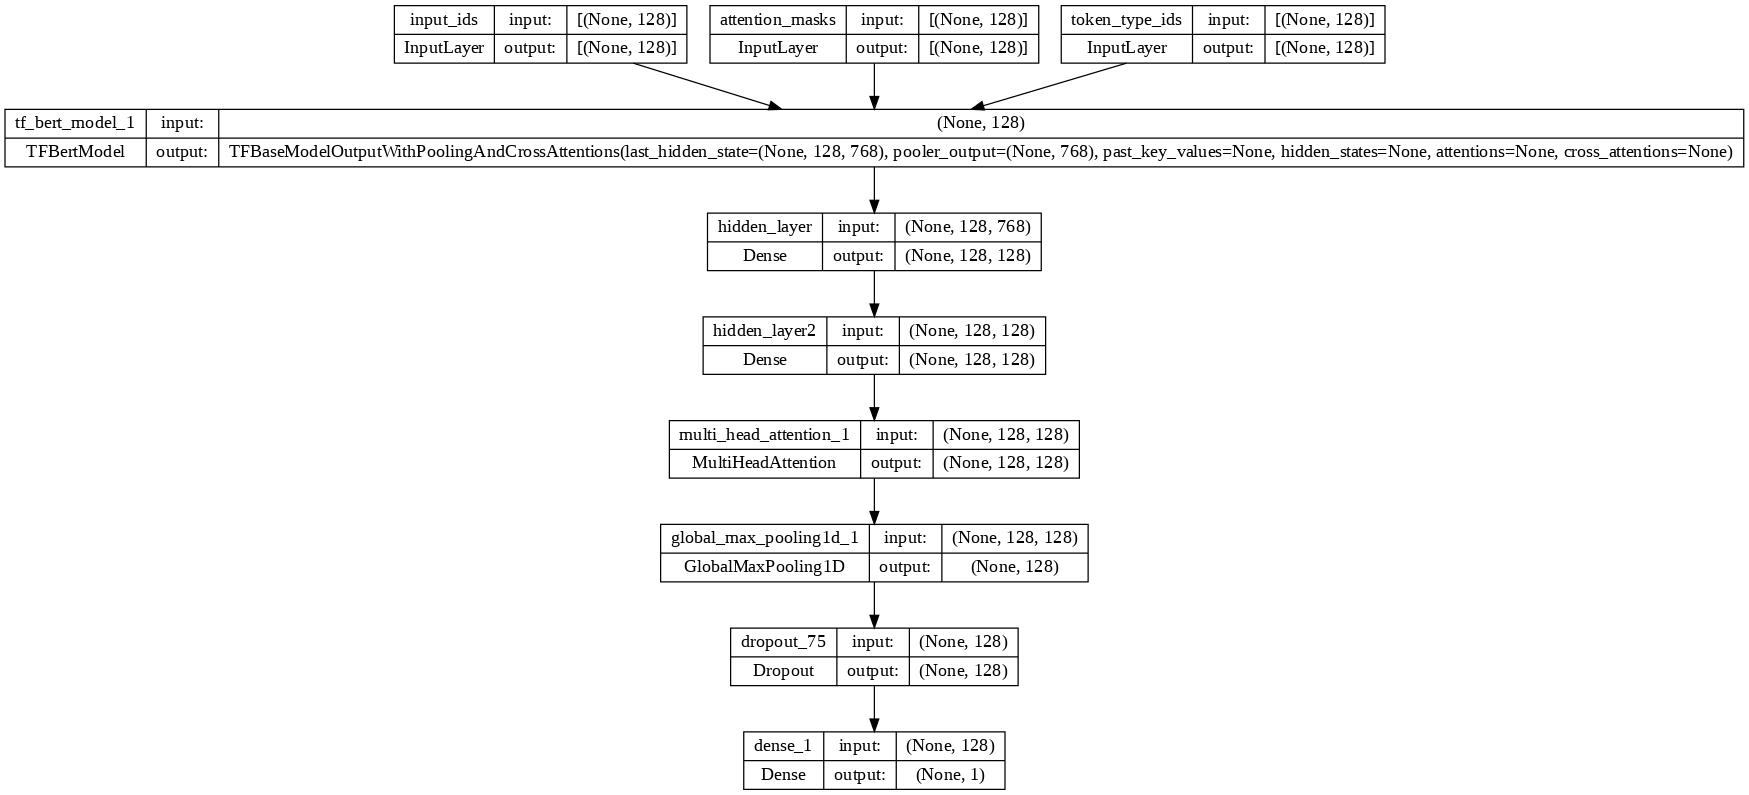

In [ ]:
keras.utils.plot_model(model2, show_shapes=True, dpi=90)

In [ ]:
class SNLIDataGeneratorFromFile(tf.keras.utils.Sequence):
    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=128,
                 batch_size=32,
                 shuffle=True):
        
        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        train_data_df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)

        train_data = []
        for index, row in train_data_df.iterrows():
            train_data.append((row[0], row[1]))

        batch_data = preprocess_data(
            train_data,
            self.tokenizer,
            self.max_length
        )

        return batch_data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [ ]:
train_data_generator = SNLIDataGeneratorFromFile(
    tokenizer=bert_tokenizer,
    n_examples=len(train),
    data_filename=train_data_path,
    batch_size=16
)

In [ ]:
test_data = preprocess_data(
    test, tokenizer=bert_tokenizer, max_length=128
)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/W266/entailment/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

## Train model

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
history=model2.fit(train_data_generator, validation_data=test_data, epochs=10,
          callbacks=[model_checkpoint_callback])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


2012/2012 [==============================] - 925s 460ms/step - loss: 0.5765 - accuracy: 0.6649 - val_loss: 0.7809 - val_accuracy: 0.5014
Epoch 2/10
2012/2012 [==============================] - 926s 460ms/step - loss: 0.5047 - accuracy: 0.7206 - val_loss: 0.6853 - val_accuracy: 0.5246
Epoch 3/10
2012/2012 [==============================] - 926s 460ms/step - loss: 0.4926 - accuracy: 0.7265 - val_loss: 0.7037 - val_accuracy: 0.5488
Epoch 4/10
2012/2012 [==============================] - 923s 459ms/step - loss: 0.4840 - accuracy: 0.7364 - val_loss: 0.7447 - val_accuracy: 0.5121
Epoch 5/10
2012/2012 [==============================] - 923s 459ms/step - loss: 0.4772 - accuracy: 0.7433 - val_loss: 0.7235 - val_accuracy: 0.5277
Epoch 6/10
2012/2012 [==============================] - 899s 447ms/step - loss: 0.4750 - accuracy: 0.7391 - val_loss: 0.6690 - val_accuracy: 0.5639
Epoch 7/10
2012/2012 [==============================] - 900s 447ms/step - loss: 0.4652 - accuracy: 0.7478 - val_loss: 0.738

In [ ]:
loss = history.history['loss'][0]
#weights = model2.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)
print(history.history['loss'])

NameError: ignored

In [ ]:
def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)

    # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
    if 'classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['classification_accuracy'])
    else:
      ax4.plot(history2.history['accuracy'])
    
    if 'val_classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['val_classification_accuracy'])
    else:
      ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

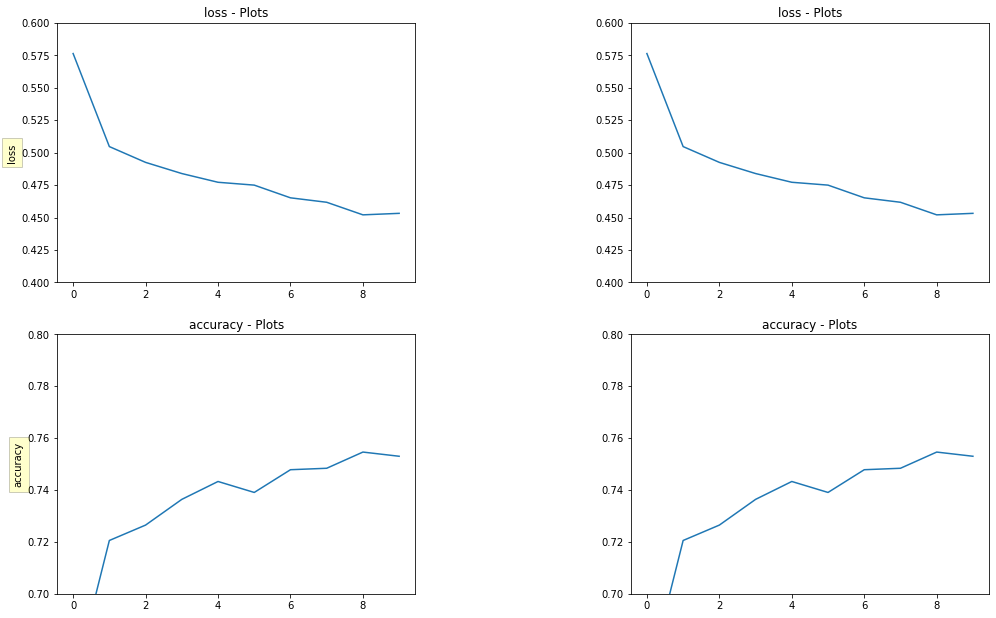

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, history, history,model_1_name='Plots', model_2_name='Plots')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()